Copyright (c) MONAI Consortium
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
    http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# MAISI Inference Tutorial

This tutorial illustrates how to use trained MAISI model and codebase to generate synthetic 3D images and paired masks.

## Setup environment

To run this tutorial, please install `xformers` by following the [official guide](https://github.com/facebookresearch/xformers#installing-xformers) 

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import generative; print(generative.__version__)" || pip install -q "monai-generative"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

0.2.3


## Setup imports

In [2]:
import os
import json
import tempfile
import torch
import monai
from monai.config import print_config
import argparse
from scripts.utils import define_instance, load_autoencoder_ckpt
from scripts.sample import check_input, LDMSampler
from scripts.utils_plot import show_image, get_xyz_plot, find_label_center_loc
from monai.transforms import LoadImage, Orientation

print_config()

MONAI version: 1.3.1+25.g64ea76d8
Numpy version: 1.26.4
Pytorch version: 2.3.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 64ea76d83a92b7cf7f13c8f93498d50037c3324c
MONAI __file__: /mnt/drive3/wenao/anaconda3/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.11.4
Pillow version: 10.2.0
Tensorboard version: 2.17.0
gdown version: 5.2.0
TorchVision version: 0.18.1+cu121
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 2.1.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.41.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:


## Setup data directory
You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.
This allows you to save results and reuse downloads.
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
directory = './'
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

./


## Read in environment setting, including data directory, model directory, and output directory

The information for data directory, model directory, and output directory are saved in ./configs/environment.json

In [4]:
args = argparse.Namespace()

environment_file = "./configs/environment.json"
env_dict = json.load(open(environment_file, "r"))
for k, v in env_dict.items():
    if "dir" in k or "path" in k:
        v = os.path.join(root_dir, v)
    setattr(args, k, v)
    print(f"{k}: {v}")
print("Global config variables have been loaded.")

output_dir: ./output
trained_autoencoder_path: ./models/autoencoder_epoch273.pt
trained_diffusion_path: ./models/input_unet3d_data-all_steps1000size512ddpm_random_current_inputx_v1.pt
trained_controlnet_path: ./models/controlnet-20datasets-e20wl100fold0bc_noi_dia_fsize_current.pt
trained_mask_generation_autoencoder_path: ./models/mask_generation_autoencoder.pt
trained_mask_generation_diffusion_path: ./models/mask_generation_diffusion_unet.pt
all_mask_files_base_dir: ./datasets/all_masks_flexible_size_and_spacing_3000
all_mask_files_json: ./configs/candidate_masks_flexible_size_and_spacing_3000.json
all_anatomy_size_conditions_json: ./configs/all_anatomy_size_condtions.json
label_dict_json: ./configs/label_dict.json
label_dict_remap_json: ./configs/label_dict_124_to_132.json
Global config variables have been loaded.


## Download dataset and trained model weights
Downloads and extracts the dataset.
Download the trained model weights.

In [ ]:
# TO DO after we finalize the link

## Read in configuration setting, including network definition, body region and anatomy to generate, etc.

The information used for both training and inference, like network definition, is stored in "./configs/config_maisi.json". Training and inference should use the same "./configs/config_maisi.json".

The information for the inference input, like body region and anatomy to generate, is stored in "./configs/config_infer.json". Please feel free to play with it.
- `"num_output_samples"`: int, the number of output image/mask pairs it will generate.
- `"spacing"`: voxel size of generated images. E.g., if set to `[1.5, 1.5, 2.0]`, it will generate images with a resolution of 1.5x1.5x2.0 mm.
- `"output_size"`: volume size of generated images. E.g., if set to `[512, 512, 256]`, it will generate images with size of 512x512x256. They need to be divisible by 16. If you have a small GPU memory size, you should adjust it to small numbers.
- `"controllable_anatomy_size"`: a list of controllable anatomy and its size scale (0--1). E.g., if set to `[["liver", 0.5],["hepatic tumor", 0.3]]`, the generated image will contain liver that have a median size, with size around 50% percentile, and hepatic tumor that is relatively small, with around 30% percentile. The output will contain paired image and segmentation mask for the controllable anatomy.
- `"body_region"`: If "controllable_anatomy_size" is not specified, "body_region" will be used to constrain the region of generated images. It needs to be chosen from "head", "chest", "thorax", "abdomen", "pelvis", "lower".
- `"anatomy_list"`: If "controllable_anatomy_size" is not specified, the output will contain paired image and segmentation mask for the anatomy in "./configs/label_dict.json".
- `"autoencoder_sliding_window_infer_size"`: in order to save GPU memory, we use sliding window inference when decoding latents to image when `"output_size"` is large. This is the patch size of the sliding window. Small value will reduce GPU memory but increase time cost. They need to be divisible by 16. 
- `"autoencoder_sliding_window_infer_overlap"`: float between 0 and 1. Large value will reduce the stitching artifacts when stitching patches during sliding window inference, but increase time cost. If you do not observe seam lines in the generated image result, you can use a smaller value to save inference time.

In [5]:
config_file = "./configs/config_maisi.json"
config_dict = json.load(open(config_file, "r"))
for k, v in config_dict.items():
    setattr(args, k, v)

# check the format of inference inputs
config_infer_file = "./configs/config_infer.json"
config_infer_dict = json.load(open(config_infer_file, "r"))
for k, v in config_infer_dict.items():
    setattr(args, k, v)
    print(f"{k}: {v}")

check_input(
    args.body_region,
    args.anatomy_list,
    args.label_dict_json,
    args.output_size,
    args.spacing,
    args.controllable_anatomy_size,
)
latent_shape = [args.latent_channels, args.output_size[0] // 4, args.output_size[1] // 4, args.output_size[2] // 4]
print("Network definition and inference inputs have been loaded.")

num_output_samples: 1
body_region: ['abdomen']
anatomy_list: ['liver']
controllable_anatomy_size: [['hepatic tumor', 0.3], ['liver', 0.5]]
num_inference_steps: 1000
mask_generation_num_inference_steps: 1000
random_seed: None
output_size: [256, 256, 256]
image_output_ext: .nii.gz
label_output_ext: .nii.gz
spacing: [1.5, 1.5, 2.0]
autoencoder_sliding_window_infer_size: [80, 80, 80]
autoencoder_sliding_window_infer_overlap: 0.25
Network definition and inference inputs have been loaded.


## Initialize networks and noise scheduler, then load the trained model weights.

The networks and noise scheduler are defined in `config_file`. We will read them in and load the model weights.

In [6]:
noise_scheduler = define_instance(args, "noise_scheduler")
mask_generation_noise_scheduler = define_instance(args, "mask_generation_noise_scheduler")

device = torch.device("cuda:7")

autoencoder = define_instance(args, "autoencoder_def").to(device)
checkpoint_autoencoder = load_autoencoder_ckpt(args.trained_autoencoder_path)
autoencoder.load_state_dict(checkpoint_autoencoder)

diffusion_unet = define_instance(args, "diffusion_unet_def").to(device)
checkpoint_diffusion_unet = torch.load(args.trained_diffusion_path)
diffusion_unet.load_state_dict(checkpoint_diffusion_unet["unet_state_dict"])
scale_factor = checkpoint_diffusion_unet["scale_factor"].to(device)

controlnet = define_instance(args, "controlnet_def").to(device)
checkpoint_controlnet = torch.load(args.trained_controlnet_path)
monai.networks.utils.copy_model_state(controlnet, diffusion_unet.state_dict())
controlnet.load_state_dict(checkpoint_controlnet["controlnet_state_dict"], strict=True)

mask_generation_autoencoder = define_instance(args, "mask_generation_autoencoder_def").to(device)
checkpoint_mask_generation_autoencoder = torch.load(args.trained_mask_generation_autoencoder_path)
mask_generation_autoencoder.load_state_dict(checkpoint_mask_generation_autoencoder)

mask_generation_diffusion_unet = define_instance(args, "mask_generation_diffusion_def").to(device)
checkpoint_mask_generation_diffusion_unet = torch.load(args.trained_mask_generation_diffusion_path)
mask_generation_diffusion_unet.load_state_dict(checkpoint_mask_generation_diffusion_unet, strict=True)
mask_generation_scale_factor = args.mask_generation_scale_factor

print("All the trained model weights have been loaded.")

2024-07-08 20:36:25,555 - INFO - 'dst' model updated: 158 of 206 variables.
All the trained model weights have been loaded.


## Define the LDM Sampler, which contains functions that will perform the inference.

In [7]:
ldm_sampler = LDMSampler(
    args.body_region,
    args.anatomy_list,
    args.all_mask_files_json,
    args.all_anatomy_size_conditions_json,
    args.all_mask_files_base_dir,
    args.label_dict_json,
    args.label_dict_remap_json,
    autoencoder,
    diffusion_unet,
    controlnet,
    noise_scheduler,
    scale_factor,
    mask_generation_autoencoder,
    mask_generation_diffusion_unet,
    mask_generation_scale_factor,
    mask_generation_noise_scheduler,
    device,
    latent_shape,
    args.mask_generation_latent_shape,
    args.output_size,
    args.output_dir,
    args.controllable_anatomy_size,
    image_output_ext=args.image_output_ext,
    label_output_ext=args.label_output_ext,
    spacing=args.spacing,
    num_inference_steps=args.num_inference_steps,
    mask_generation_num_inference_steps=args.mask_generation_num_inference_steps,
    random_seed=args.random_seed,
    autoencoder_sliding_window_infer_size=args.autoencoder_sliding_window_infer_size,
    autoencoder_sliding_window_infer_overlap=args.autoencoder_sliding_window_infer_overlap,
)

## Perform the inference
**Time cost:** It will take around 80s to generate a [256,256,256] mask, and another 105s to generate the corresponding [256,256,256] image on one A100. The time cost per mask is fixed; time cost per image is roughly linear to the output size. i.e., if we want to generate a [512,512,512] image/mask pair, it will take around 80s to generate a [256,256,256] mask and then resample it to a [512,512,512] mask. The time cost for [512,512,512] image generatation will be 8 times longer, around 8x105s~14min. 

**GPU memory:** Decoding the latents into image with autoencoder is the step that consumes the largest GPU memory. The mask generation takes 34G. For image generation, to save GPU memory, we use sliding window inference for the autoencoder when the `output_size` is large. So the GPU memory for image generation is not strictly linear to the output_size. For [256,256,256], it takes 34G. For [512,512,512], it takes 67G.

In [ ]:
print(f"The generated image/mask pairs will be saved in {args.output_dir}.")
output_filenames = ldm_sampler.sample_multiple_images(args.num_output_samples)
print("MAISI image/mask generation finished")

## Visualize the results


Visualizing ./output/sample_20240708_195612_681240_image.nii.gz and ./output/sample_20240708_195612_681240_label.nii.gz...
1 [metatensor(82), metatensor(116), metatensor(84)]


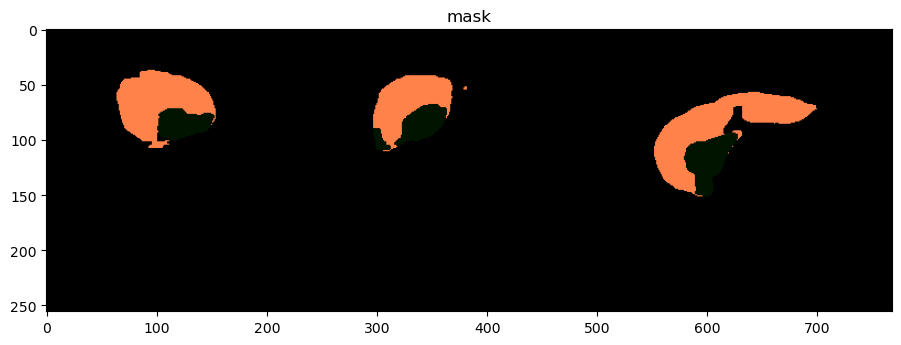

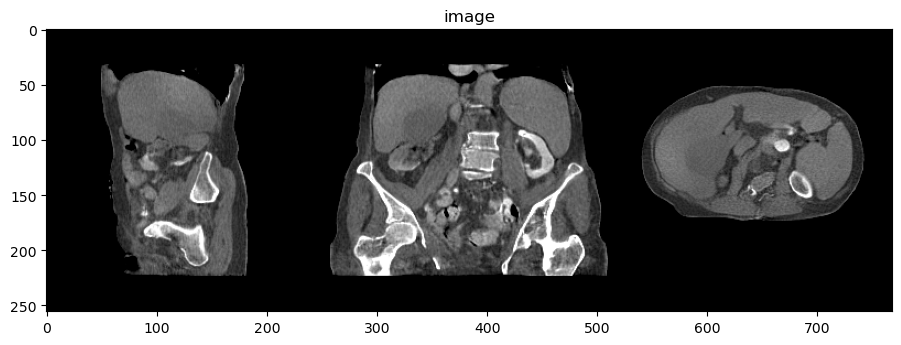

In [14]:
visualize_image_filename = './output/sample_20240708_195612_681240_image.nii.gz'#output_filenames[0][0]
visualize_mask_filename = './output/sample_20240708_195612_681240_label.nii.gz'#output_filenames[0][1]
print(f"Visualizing {visualize_image_filename} and {visualize_mask_filename}...")

# load image/mask pairs
loader = LoadImage(image_only=True, ensure_channel_first=True)
orientation = Orientation(axcodes="RAS")
image_volume = orientation(loader(visualize_image_filename))
mask_volume = orientation(loader(visualize_mask_filename)).to(torch.uint8)

# visualize for CT HU intensity between [-200, 500]
image_volume = torch.clip(image_volume, -200, 500)
image_volume = image_volume - torch.min(image_volume)
image_volume = image_volume / torch.max(image_volume)

# create a random color map for mask visualization
colorize = torch.clip(torch.cat([torch.zeros(3, 1, 1, 1), torch.randn(3, 200, 1, 1)], 1), 0, 1)
target_class_index = 1

# find center voxel location for 2D slice visualization
center_loc_axis = find_label_center_loc(torch.flip(mask_volume[0, ...] == target_class_index, [-3, -2, -1]))

# visualization
vis_mask = get_xyz_plot(
    mask_volume, center_loc_axis, mask_bool=True, n_label=201, colorize=colorize, target_class_index=target_class_index
)
show_image(vis_mask, title="mask")

vis_image = get_xyz_plot(image_volume, center_loc_axis, mask_bool=False)
show_image(vis_image, title="image")